### Importing libraries

In [187]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import yfinance as yf 

from sklearn.preprocessing import MinMaxScaler

### Getting the Stock Data

In [188]:
ticker = "NVDA"

start_training_date = datetime.date(2017, 10, 1)
end_training_date = datetime.date(2022, 7, 1)

start_testing_date = datetime.date(2022, 7, 2)
end_testing_date = datetime.date(2022,10,28)

In [189]:
df_training = yf.download(ticker, start=start_training_date, end=end_training_date, progress= False)
print(f"Downloaded {df_training.shape[0]} rows and {df_training.shape[1]} columns of {ticker} data")

df_testing = yf.download(ticker, start=start_testing_date - datetime.timedelta(days=60), end=end_testing_date, progress=False)
print(f"Downloaded {df_testing.shape[0]} rows and {df_testing.shape[1]} columns of {ticker} data")

df_full = yf.download(ticker, start=start_training_date - datetime.timedelta(days=60), end=end_testing_date, progress=False)
print(f"Downloaded {df_full.shape[0]} rows and {df_full.shape[1]} columns of {ticker} data")

Downloaded 1195 rows and 6 columns of NVDA data
Downloaded 124 rows and 6 columns of NVDA data
Downloaded 1320 rows and 6 columns of NVDA data


### Restructuring the dataset

In [190]:
steps = -1

# Adding a Mean column for the mean of the high and low stock price
df_full['Mean'] = (df_full['High'] + df_full['Low']) / 2

# Adding an Actual column for the stock prices for the following day (following the steps)
df_full['Actual'] = df_full['Mean'].shift(steps)
# Dropping NA
df_full = df_full.dropna()
df_full.head(3)

,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
Date,,,,,,,,
2017-08-02,41.437500,41.477501,40.317501,41.097500,40.629242,47844400,40.897501,41.288750
2017-08-03,41.092499,41.657501,40.919998,41.619999,41.145779,44242000,41.288750,42.068750
2017-08-04,41.849998,42.517502,41.619999,41.802502,41.326195,58909600,42.068750,42.546249


Text(0.5, 1.0, 'NVDA Stock Price')

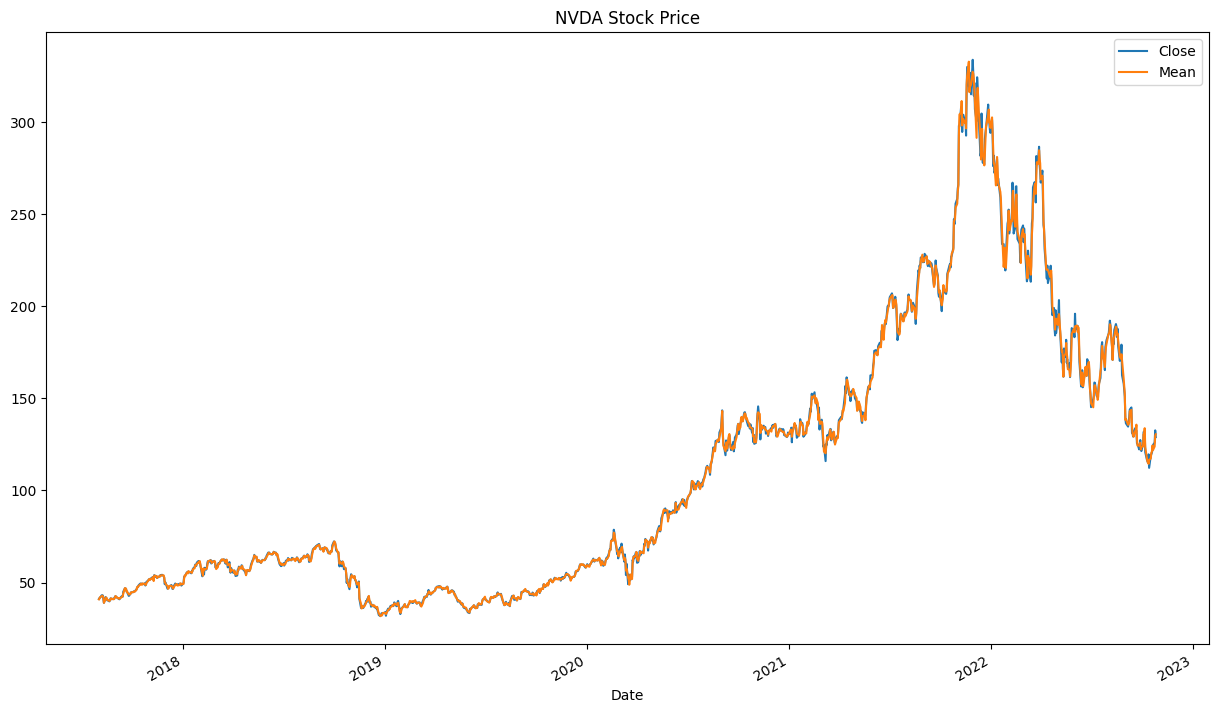

In [191]:
# Plotting the closing price
df_full[['Close','Mean']].plot( figsize=(15,9))
plt.legend(['Close', 'Mean'])
plt.title('NVDA Stock Price')

Text(0.5, 1.0, 'NVDA Stock Volume')

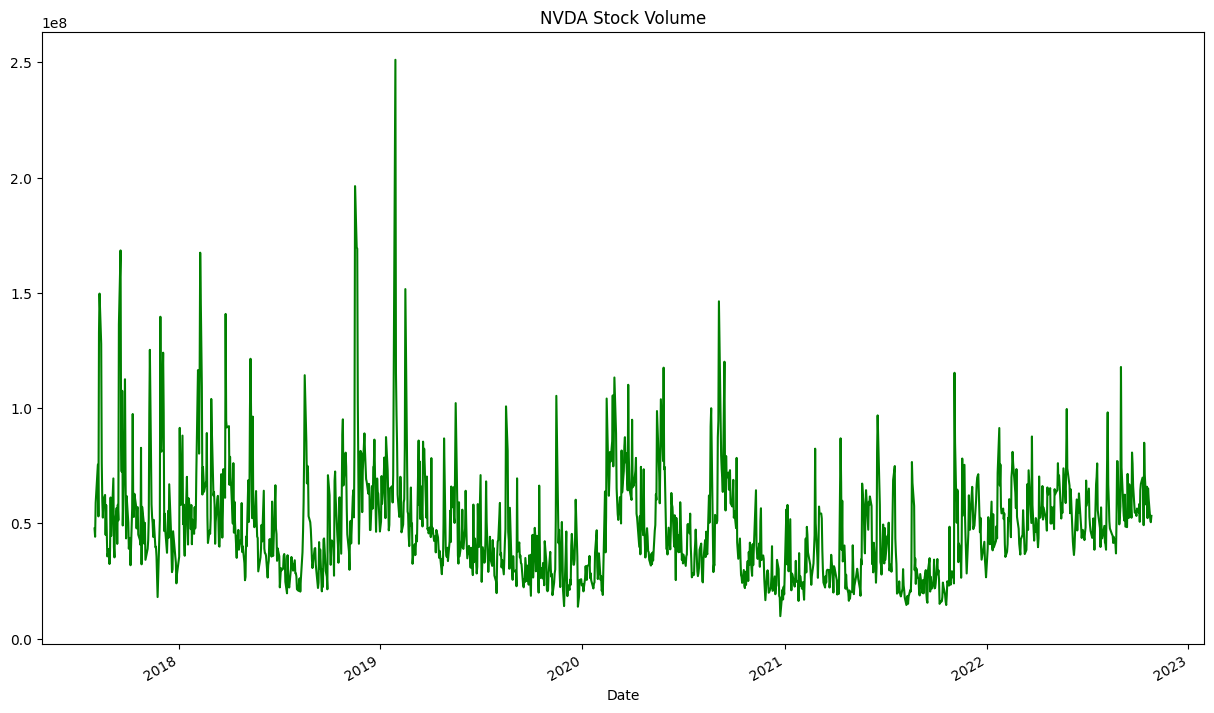

In [192]:
# Plotting the volume of NVDA sold daily
df_full['Volume'].plot(color='green', figsize=(15,9))
plt.title("NVDA Stock Volume")

### Normalizing the input and target features

In [193]:
# Scaling the input factors
sc_input = MinMaxScaler(feature_range=(0,1))
df_input = sc_input.fit_transform(df_full.iloc[:,:-1])
df_input = pd.DataFrame(df_input, columns=['Open','High','Low','Close','Adj Close','Volume','Mean'], index = df_full.index)
X = df_input


# Scaling the output (Actual Closing Price)
sc_output = MinMaxScaler(feature_range=(0,1))
df_output = sc_output.fit_transform(df_full.iloc[:, -1:])
df_output = pd.DataFrame(df_output, columns=['Stock Price next day'],index = df_full.index)
y = df_output

### Splitting into training and test set

In [194]:
# Splitting into 70:30 
train_size = int(len(df_full) * 0.7)
test_size = int(len(df_full)) - train_size

train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

### Understanding the Trend, Seasonality and Random Noise

In [195]:
import statsmodels.api as sm

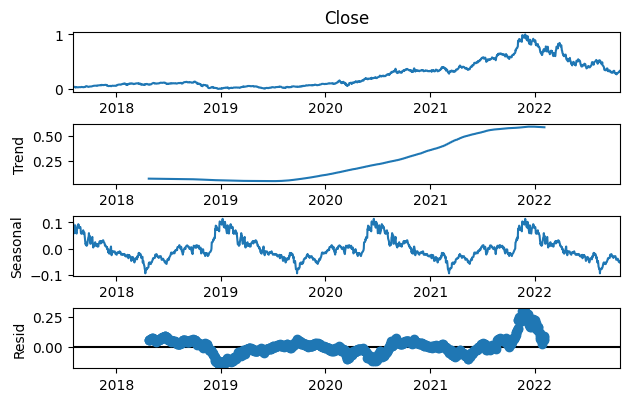

In [196]:
seas_d = sm.tsa.seasonal_decompose(X['Close'], model = 'add', period = 365)

fig = seas_d.plot()
fig.set_figheight(4)
plt.show()

### Checking for Data Stationarity using ADF test

If the data is stationary, it means that the mean and variance remains the same in the future and thus would be easier to predict future values.

The function created below is used to check the p-value of the ADF test results. If the p-value is less than 0.05, the data would be stationary, else it is not.

In [197]:
from statsmodels.tsa.stattools import adfuller

def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [198]:
y_test=y['Stock Price next day'][:train_size].dropna()
test_adf(y_test, "Stock Price")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Price


In [199]:
# Checking if data can be made stationary by applying one difference
test_adf(y_test.diff(), 'Stock Price')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Price


### Building the model 

Applying ARIMA and SARIMAX to the data to see which model works better. To do so, there is a need to find out the AR and the MA terms to correct any autocorrelation in the differenced series by using ACF and PACF plots of the differenced series.

ACF: bar chart of the coeficients of correlation between a time series and its lags (determines the value of p or the AR term)

PACF: plot of the partial correlation coefficients between the series and lags of itself (determines the value of the q or the MA term)

c:\Users\josep\anaconda3\envs\fintech\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


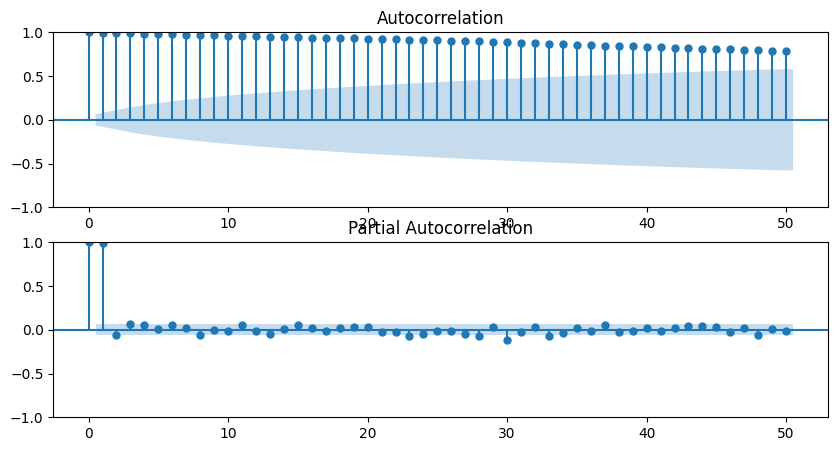

In [200]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

The PACF plot shows a significant spike at lag 1 and 2 -> higher-order autocorrelations are explained by the lag 1 and 2 autocorrelations.

We can use a pyramid auto ARIMA to perform stepwise search for AR and MA term that gives the lowest value of AIC

In [201]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
                    exogenous= train_X,
                    start_p=1, start_q=1, 
                    max_p=7, max_q=7, 
                    d=1, max_d=7,
                    trace=True, 
                    error_action='ignore', 
                    suppress_warnings=True, 
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6901.349, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6869.358, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6900.443, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6903.192, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6868.007, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6901.394, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6899.490, Time=0.91 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6902.758, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.387 seconds


In [202]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  923
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3454.596
Date:                Sat, 29 Oct 2022   AIC                          -6903.192
Time:                        22:01:18   BIC                          -6888.713
Sample:                             0   HQIC                         -6897.667
                                - 923                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.490      0.136      -0.000       0.001
ma.L1          0.2021      0.019     10.710      0.000       0.165       0.239
sigma2      3.254e-05   7.65e-07     42.537      0.000     3.1e-05     3.4e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1491.52
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               5.84   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model suggested by auto_arima is SARIMAX and the value of p,d,q is 1,1,0 respectively

### Train the model using SARIMAX

In [203]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
                exog=train_X,
                order=(1,1,0),
                enforce_invertibility=False, enforce_stationarity=False)

c:\Users\josep\anaconda3\envs\fintech\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\josep\anaconda3\envs\fintech\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [204]:
# Fitting the model
results = model.fit()

c:\Users\josep\anaconda3\envs\fintech\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [205]:
# Predictions and forecasting using predict() and forecast()
predictions= results.predict(start =train_size, end=train_size+test_size+(steps),exog=test_X)

forecast_1= results.forecast(steps=test_size, exog=test_X)

c:\Users\josep\anaconda3\envs\fintech\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\josep\anaconda3\envs\fintech\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [206]:
# Plotting the predictions
act= pd.DataFrame(df_output.iloc[train_size:, 0])

predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

<AxesSubplot:xlabel='Date'>

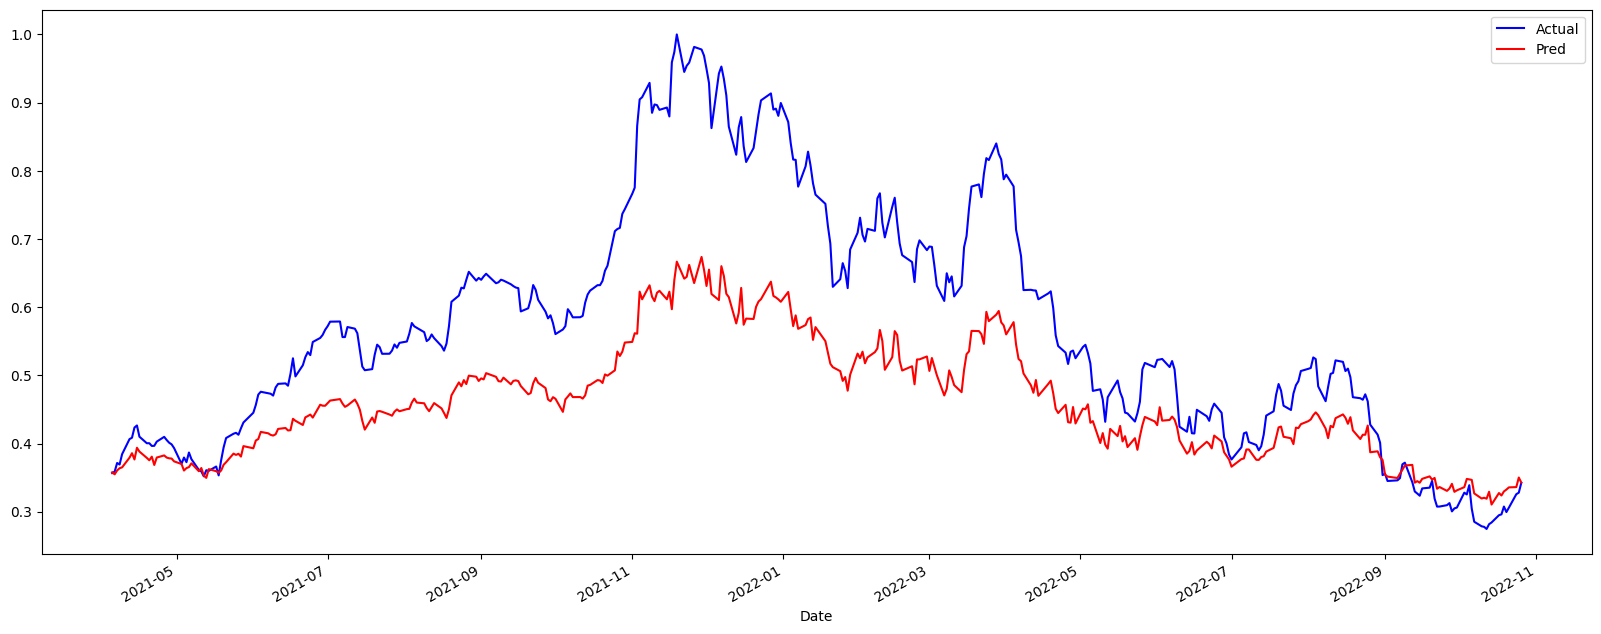

In [207]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

In [208]:
final_forecast = pd.DataFrame(forecast_1)
final_forecast.reset_index(drop=True, inplace=True)
final_forecast.index=test_X.index
final_forecast['Actual'] =df_output.iloc[train_size:, 0]
final_forecast.rename(columns={'predicted_mean':'Forecast'}, inplace=True)

<AxesSubplot:xlabel='Date'>

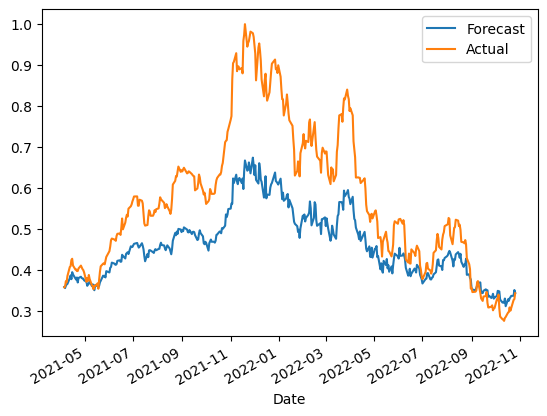

In [209]:
final_forecast['Forecast'].plot(legend=True)
final_forecast['Actual'].plot(legend=True)

In [210]:
predictions.tail()

,Pred,Actual
Date,,
2022-10-20,0.332448,0.299460
2022-10-21,0.335670,0.305923
2022-10-24,0.336104,0.325696
2022-10-25,0.350115,0.327889
2022-10-26,0.342878,0.342245


### Evaluating the model

In [211]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['Actual'])
error

0.1420510324080953

In [212]:
## Scaling back to the original values
trainPredict = sc_output.inverse_transform(predictions[['Pred']])
testPredict = sc_output.inverse_transform(predictions[['Actual']])

In [213]:
predictions_temp = results.get_forecast(steps = 14, exog=test_X[-14:])

c:\Users\josep\anaconda3\envs\fintech\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [214]:
predictions_temp.predicted_mean.to_numpy().reshape(14,1)

array([[0.32693519],
       [0.31931384],
       [0.32049029],
       [0.31906048],
       [0.3292291 ],
       [0.31050453],
       [0.32739886],
       [0.32378951],
       [0.32974412],
       [0.33244751],
       [0.33567029],
       [0.33610418],
       [0.35011533],
       [0.34287822]])

In [215]:
ans = sc_output.inverse_transform(predictions_temp.predicted_mean.to_numpy().reshape(14,1))
ans = pd.DataFrame(ans, index = np.arange(datetime.date(2022,10,29),  datetime.date(2022, 11, 12)), columns = ['Prediction'])
ans.to_csv("Model2.csv")

Things to improve on:

1) Try to see how to predict future prices without exog
2) See how to include external economic indicators (possibly to the exog)